# Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd  '/content/gdrive/MyDrive/HCML/Explainability'

Mounted at /content/gdrive
/content/gdrive/MyDrive/HCML/Explainability


# Data Preparation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit

diabetes_dataset = pd.read_csv('diabetes_130_raw.csv')
diabetes_dataset.drop(axis=1, columns=['weight', 'medical_specialty', 'payer_code'], inplace=True)
diabetes_dataset = diabetes_dataset.sort_values(by=['patient_nbr', 'encounter_id'])
# Define the ranges and replacement values
ICD9_mapping = [
    ((1, 139), 'Infectious And Parasitic Diseases'),
    ((140, 239), 'Neoplasms'),
    ((240, 279), 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders'),
    ((280, 289), 'Diseases Of The Blood And Blood-Forming Organs'),
    ((290, 319), 'Mental Disorders'),
    ((320, 389), 'Diseases Of The Nervous System And Sense Organs'),
    ((390, 459), 'Diseases Of The Circulatory System'),
    ((460, 519), 'Diseases Of The Respiratory System'),
    ((520, 579), 'Diseases Of The Digestive System'),
    ((580, 629), 'Diseases Of The Genitourinary System'),
    ((630, 679), 'Complications Of Pregnancy, Childbirth, And The Puerperium'),
    ((680, 709), 'Diseases Of The Skin And Subcutaneous Tissue'),
    ((710, 739), 'Diseases Of The Musculoskeletal System And Connective Tissue'),
    ((740, 759), 'Congenital Anomalies'),
    ((760, 779), 'Certain Conditions Originating In The Perinatal Period'),
    ((780, 799), 'Symptoms, Signs, And Ill-Defined Conditions'),
    ((800, 999), 'Injury And Poisoning'),
    ('V', 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services'),
    ('E', 'Supplementary Classification Of External Causes Of Injury And Poisoning')
]

# Custom function to replace values based on multiple ranges
def replace_multiple_ranges(x, ranges_and_values):
    for values, new_value in ranges_and_values:
        if type(values) == tuple and x[0] != 'V' and x[0] != 'E' and x != '?':
            if values[0] <= int(float(x)) <= values[1]:
                return new_value
        elif type(values) == str and x[0] == values:
            return new_value
    return x

# Apply the custom function to the diagnosis columns
diabetes_dataset['diag_1'] = diabetes_dataset['diag_1'].apply(replace_multiple_ranges, args=(ICD9_mapping,))
diabetes_dataset['diag_2'] = diabetes_dataset['diag_2'].apply(replace_multiple_ranges, args=(ICD9_mapping,))
diabetes_dataset['diag_3'] = diabetes_dataset['diag_3'].apply(replace_multiple_ranges, args=(ICD9_mapping,))

# Replace '?' with 'no record' across diag_2 and diag_3
diabetes_dataset[['diag_2', 'diag_3']] = diabetes_dataset[['diag_2', 'diag_3']].replace('?', 'no record')

# Replace '?' with NaN
diabetes_dataset[['race', 'diag_1']] = diabetes_dataset[['race', 'diag_1']].replace('?', np.nan)

# Drop rows with missing values in columns 'race' and 'diag_1'
diabetes_dataset.dropna(subset=['race', 'diag_1'], inplace=True)

admission_type_id_mapping = {1:'Emergency',
                             2:'Urgent',
                             3:'Elective',
                             4:'Newborn',
                             5:'Not Available',
                             6:'NULL',
                             7:'Trauma Center',
                             8:'Not Mapped'
                            }

discharge_disposition_id_mapping = {1: 'ischarged to home',
                                    2:'ischarged/transferred to another short term hospital',
                                    3:'ischarged/transferred to SNF',
                                    4:'ischarged/transferred to ICF',
                                    5:'ischarged/transferred to another type of inpatient care institution',
                                    6:'ischarged/transferred to home with home health service',
                                    7:'eft AMA',
                                    8:'ischarged/transferred to home under care of Home IV provider',
                                    9:'dmitted as an inpatient to this hospital',
                                    10:'Neonate discharged to another hospital for neonatal aftercare',
                                    11:'Expired',
                                    12:'Still patient or expected to return for outpatient services',
                                    13:'Hospice / home',
                                    14:'Hospice / medical facility',
                                    15:'Discharged/transferred within this institution to Medicare approved swing bed',
                                    16:'Discharged/transferred/referred another institution for outpatient services',
                                    17:'Discharged/transferred/referred to this institution for outpatient services',
                                    18:'NULL',
                                    19:'Expired at home. Medicaid only, hospice.',
                                    20:'Expired in a medical facility. Medicaid only, hospice.',
                                    21:'Expired, place unknown. Medicaid only, hospice.',
                                    22:'Discharged/transferred to another rehab fac including rehab units of a hospital.',
                                    23:'Discharged/transferred to a long term care hospital.',
                                    24:'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
                                    25:'Not Mapped',
                                    26:'Unknown/Invalid',
                                    30:'Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere',
                                    27:'Discharged/transferred to a federal health care facility.',
                                    28:'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
                                    29:'Discharged/transferred to a Critical Access Hospital (CAH).'
                                    }

admission_source_id_mapping = {1: 'Physician Referral',
                               2: 'Clinic Referral',
                               3: 'HMO Referral',
                               4: 'Transfer from a hospital',
                               5: 'Transfer from a Skilled Nursing Facility (SNF)',
                               6: 'Transfer from another health care facility',
                               7: 'Emergency Room',
                               8: 'Court/Law Enforcement',
                               9: 'Not Available',
                               10:' Transfer from critial access hospital',
                               11:' Normal Delivery',
                               12:' Premature Delivery',
                               13:' Sick Baby',
                               14:' Extramural Birth',
                               15:' Not Available',
                               17:' NULL',
                               18:' Transfer From Another Home Health Agency',
                               19:' Readmission to Same Home Health Agency',
                               20:' Not Mapped',
                               21:' Unknown/Invalid',
                               22:' Transfer from hospital inpt/same fac reslt in a sep claim',
                               23:' Born inside this hospital',
                               24:' Born outside this hospital',
                               25:' Transfer from Ambulatory Surgery Center',
                               26:' Transfer from Hospice'
                               }

diabetes_dataset['admission_type_id'] = diabetes_dataset['admission_type_id'].replace(admission_type_id_mapping)
diabetes_dataset['discharge_disposition_id'] = diabetes_dataset['discharge_disposition_id'].replace(discharge_disposition_id_mapping)
diabetes_dataset['admission_source_id'] = diabetes_dataset['admission_source_id'].replace(admission_source_id_mapping)

## Feature Importance

In [ ]:
# Function to calculate differences between consecutive rows
def calculate_differences(diabetes_dataset, idx1, idx2):
    differences = {}
    for column in diabetes_dataset.columns:
        if column != 'readmitted':
            if pd.api.types.is_numeric_dtype(diabetes_dataset[column]):
                differences[column] = diabetes_dataset.at[idx1, column] - diabetes_dataset.at[idx2, column]
            else:
                differences[column] = 1 if diabetes_dataset.at[idx1, column] != diabetes_dataset.at[idx2, column] else 0
    return differences

# Function to identify shifts and calculate differences within a group
def process_group(group):
    shifts = ((group['readmitted'] == '<30') & ((group['readmitted'].shift(1) == 'NO') | (group['readmitted'].shift(1) == '>30')))
    shift_indices = group.index[shifts]


    differences_list = []
    for idx in shift_indices:
        if idx > group.index.min():
            prev_idx = group.index[group.index.get_loc(idx) - 1]  # Safely get the previous index
            differences = calculate_differences(group, prev_idx, idx)
            differences_list.append(differences)

    return differences_list



# Apply the function to each group and collect all differences
all_differences = []
for patient_id, group in diabetes_dataset.groupby('patient_nbr'):
    all_differences.extend(process_group(group))

# Convert list of differences to a DataFrame
differences_diabetes_dataset = pd.DataFrame(all_differences)

# Calculate the mean differences (normalize by the number of shifts)
normalized_differences = differences_diabetes_dataset.abs().mean()

# Get feature names with normalized difference value below 0.01
features_below_threshold = normalized_differences[normalized_differences < 0.01].index.tolist()


# Ensure the column to keep is not in the columns to drop
columns_to_drop = [col for col in features_below_threshold if col != 'patient_nbr']

diabetes_dataset_important_features = diabetes_dataset.drop(columns_to_drop, axis=1)
diabetes_dataset_important_features.drop(['encounter_id'], axis=1, inplace=True)
diabetes_dataset_important_features.drop(['patient_nbr'], axis=1, inplace=True)

## Encoding

In [ ]:
def sparse_encode(df):
    # select all categorical columns
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']

    # Convert string columns to categorical
    for col in categorical_columns:
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.codes.astype('category')

# Define the unique identifier column
def load_data(df):

    # encode dataframe first
    sparse_encode(df)

    '''
    unique_id_column = 'patient_nbr'

    # Split into training and remaining sets (validation + test)
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, remaining_idx = next(splitter.split(df, groups=df[unique_id_column]))

    train_df = df.iloc[train_idx]
    test_df = df.iloc[remaining_idx]

    # Split remaining set into validation and test sets
    #splitter = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    #val_idx, test_idx = next(splitter.split(remaining_df, groups=remaining_df[unique_id_column]))

    #val_df = remaining_df.iloc[val_idx]
    #test_df = remaining_df.iloc[test_idx]

    # remove patient number after use for splitting
    train_df, test_df = train_df.drop(['patient_nbr'], axis=1), test_df.drop(['patient_nbr'], axis=1)
    diabetes_dataset_important_features.drop(['patient_nbr'], axis=1)

    train_y = train_df['readmitted']
    train_df.drop(['readmitted'], axis=1, inplace=True)
    train_x = train_df

    test_y = test_df['readmitted']
    test_df.drop(['readmitted'], axis=1, inplace=True)
    test_x = test_df
    '''

    #return train_x, train_y, test_x, test_y

In [ ]:
load_data(diabetes_dataset_important_features)

In [ ]:
import pandas as pd

def get_encoded_mapping(df, column_name):
    """
    This function returns a dictionary mapping the unique values of the specified column
    to their corresponding encoded values.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the categorical column.
    column_name (str): The name of the column to get the mapping for.

    Returns:
    dict: A dictionary mapping original categorical values to encoded values.
    """
    # Ensure the specified column is of categorical type
    if not pd.api.types.is_categorical_dtype(df[column_name]):
        df[column_name] = df[column_name].astype('category')

    # Get the encoded values
    encoded_values = df[column_name].cat.codes

    # Create the mapping
    value_to_encoded_mapping = {value: code for value, code in zip(df[column_name], encoded_values)}

    return value_to_encoded_mapping


# Get the mapping for the 'Category' column
mapping = get_encoded_mapping(diabetes_dataset, 'readmitted')

print("Mapping from original values to encoded numbers:", mapping)


Mapping from original values to encoded numbers: {'<30': 0, '>30': 1, 'NO': 2}


In [ ]:
# used for TAN
variables_names = diabetes_dataset_important_features.columns.values
target_variable = variables_names[-1]
feature_variables = variables_names[:-1]

mask = np.random.rand(len(diabetes_dataset_important_features)) < 0.8
train = diabetes_dataset_important_features[mask]
test = diabetes_dataset_important_features[~mask]
test_no_target = test.copy().drop(target_variable, axis=1).reset_index()
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")

Training set shape: (79423, 28)
Test set shape: (20051, 28)


In [ ]:
state_names = {name: column.unique().tolist() for name, column in diabetes_dataset_important_features.items()}

# Training

In [ ]:
!pip install pgmpy
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def accuracy(test_data, predicted_data):
    '''
    Return a percentage representing the classification accuracy
    over the test set
    '''
    predicted_column = []
    keys = list(predicted_data.keys())

    for val in zip(*predicted_data.values()):
        max_index = np.argmax(val)
        predicted_column.append(keys[max_index])

    predicted_column = pd.Series(predicted_column, index=test_data.index)

    return accuracy_score(test_data, predicted_column) * 100

def precision(test_data, predicted_data, average='macro'):
    '''
    Return the classification precision over the test set
    for multiclass classification.
    '''
    return precision_score(test_data, predicted_data, average=average) * 100

def recall(test_data, predicted_data, average='macro'):
    '''
    Return the classification recall over the test set
    for multiclass classification.
    '''
    return recall_score(test_data, predicted_data, average=average) * 100

def f_measure(test_data, predicted_data, average='macro'):
    '''
    Return the classification F1 score over the test set
    for multiclass classification.
    '''
    return f1_score(test_data, predicted_data, average=average) * 100

def predict(data, inf, target_variable):
    '''
    Given a Dataframe, an inference object and a target variable,
    perform prediction and return the obtained results
    '''
    results = defaultdict(list)
    for _, data_point in data.iterrows():
        if 'index' in data_point:
            del data_point['index']
        result = inf.query(
            variables=[target_variable],
            evidence=data_point.to_dict(),
            show_progress=False,
        )
        values = result.state_names[target_variable]
        for i, val in enumerate(values):
            results[val].append(result.values[i])
    return results

def perf_measure(test_data, predicted_data, positive_class, negative_class):
    '''
    Return the number of true positives, false positives, true negatives and
    false negatives
    '''
    tp, fp, tn, fn = 0, 0, 0, 0
    predicted_column = []
    keys = list(predicted_data.keys())
    for val in zip(*predicted_data.values()):
        max_index = np.argmax(val)
        predicted_column.append(keys[max_index])
    predicted_column = pd.Series(predicted_column, index=test_data.index)
    for actual, pred in zip(test_data, predicted_column):
        if actual == pred == positive_class:
           tp += 1
        if pred == positive_class and actual != pred:
           fp += 1
        if actual == pred == negative_class:
           tn += 1
        if pred == negative_class and actual != pred:
           fn += 1

    return (tp, fp, tn, fn)

### TAN

In [ ]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.estimators import StructureEstimator
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG
from sklearn.metrics import mutual_info_score

def conditional_mutual_info_score(xi, xj, c):
    '''
    Compute conditional mutual information I(Xi, Xj | C), given
    numpy arrays or pandas series for xi and xj and a numpy matrix
    or a a pandas dataframe for c.
    In this implementation c can be given as a single column or as
    multiple columns.
    '''
    conditions = pd.DataFrame(c)
    if len(conditions.columns) == 0:
        return mutual_info_score(xi, xj)
    cond_mutual_info = 0
    for _, cond in conditions.items():
        unique_condition_values = cond.unique()
        for i in unique_condition_values:
            condition_proba = np.sum(cond == i) / len(cond)
            cond_mutual_info += mutual_info_score(
                xi[cond == i], xj[cond == i],
            ) * condition_proba
    return np.sum(cond_mutual_info)

class TreeAugmentedNaiveBayesSearch(StructureEstimator):

    def __init__(self, data, class_node, root_node=None, **kwargs):
        '''
        Search class for learning tree-augmented naive bayes (TAN) graph structure with a given set of variables.
        TAN is an extension of Naive Bayes classifer and allows a tree structure over the independent variables
        to account for interaction.
        See https://github.com/pgmpy/pgmpy/pull/1266/commits for reference.
        '''
        self.class_node = class_node
        self.root_node = root_node

        super().__init__(data, **kwargs)

    def estimate(self):
        '''
        Estimates the DAG structure that fits best to the given data set using the Chow-Liu algorithm.
        Only estimates network structure, no parametrization.
        '''
        if self.class_node not in self.data.columns:
            raise ValueError("Class node must exist in data")

        if self.root_node is not None and self.root_node not in self.data.columns:
            raise ValueError("Root node must exist in data")

        graph = nx.Graph()
        df_features = self.data.loc[:, self.data.columns != self.class_node]
        total_cols = len(df_features.columns)
        for i in range(total_cols):
            from_node = df_features.columns[i]
            graph.add_node(from_node)
            for j in range(i + 1, total_cols):
                to_node = df_features.columns[j]
                graph.add_node(to_node)
                mi = mutual_info_score(
                    df_features.iloc[:, i], df_features.iloc[:, j]
                )
                graph.add_edge(from_node, to_node, weight=mi)
        tree = nx.maximum_spanning_tree(graph)

        if self.root_node:
            digraph = nx.bfs_tree(tree, self.root_node)
        else:
            digraph = nx.bfs_tree(tree, df_features.columns[0])

        for node in df_features.columns:
            digraph.add_edge(self.class_node, node)

        return DAG(digraph)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs


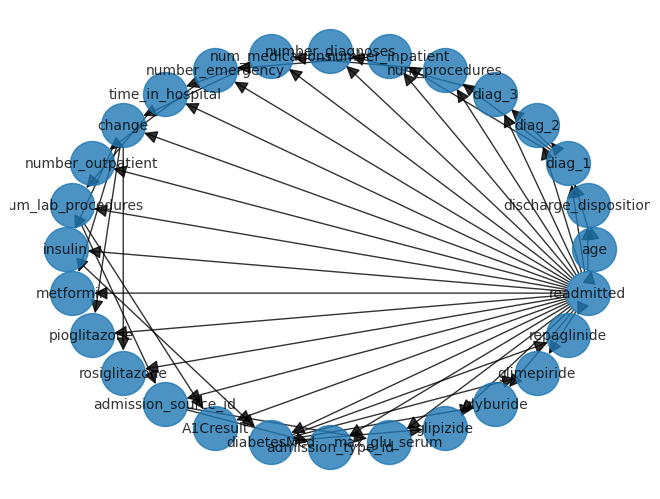

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import NaiveBayes, BayesianModel

%time
tan_estimator = TreeAugmentedNaiveBayesSearch(data=diabetes_dataset_important_features, class_node=target_variable)
tan_structure = tan_estimator.estimate()
tan_model = BayesianModel(tan_structure.edges)
nx.draw_circular(tan_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

The TAN model, without the target variable, is a tree.


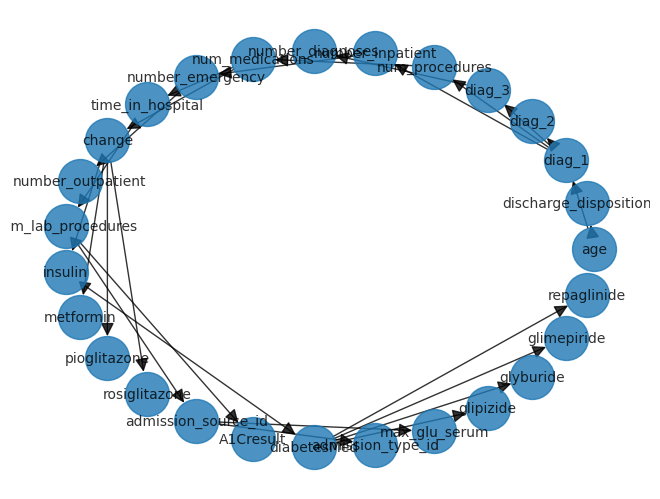

In [ ]:
tree_check = tan_structure.copy()
tree_check.remove_node(target_variable)
if nx.is_tree(tree_check):
    print('The TAN model, without the target variable, is a tree.')
else:
    print('The TAN model, without the target variable, is not a tree.')
nx.draw_circular(tree_check, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)

#### Dependecies

The FAN model, without the target variable, is a forest.


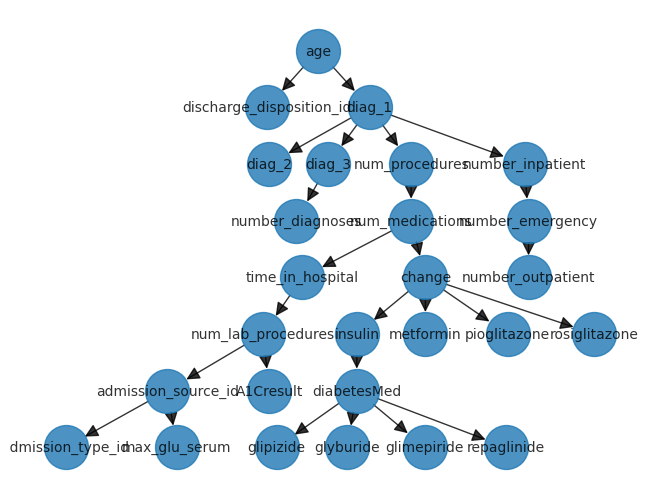

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import subprocess

tan_check = tan_structure.copy()
tan_check.remove_node(target_variable)

if nx.is_forest(tan_check):
    print('The FAN model, without the target variable, is a forest.')
else:
    print('The FAN model, without the target variable, is not a forest.')

# Export the NetworkX graph to a DOT file
nx.drawing.nx_pydot.write_dot(tan_check, 'forest_check.dot')

# Use Graphviz to generate a layout file
subprocess.run(['dot', '-Tplain', 'forest_check.dot', '-o', 'forest_check_layout.txt'])

# Read the layout file to extract node positions
pos = {}
with open('forest_check_layout.txt') as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith('node'):
            parts = line.split()
            node_id = parts[1]
            x = float(parts[2])
            y = float(parts[3])
            pos[node_id] = (x, y)

# Draw the graph using NetworkX with the extracted positions
nx.draw(tan_check, pos, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()


The FAN model, without the target variable, is a forest.


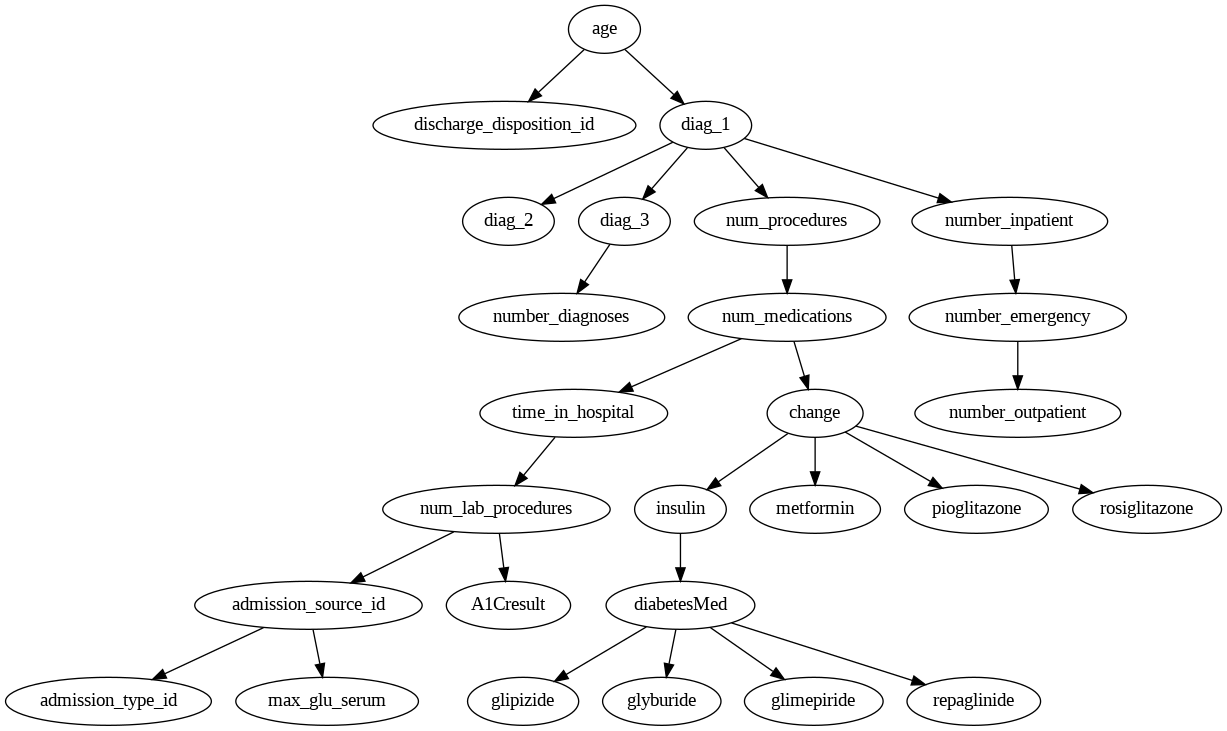

In [ ]:
import networkx as nx
import graphviz
from IPython.display import Image

tan_check = tan_structure.copy()
tan_check.remove_node(target_variable)

if nx.is_forest(tan_check):
    print('The FAN model, without the target variable, is a forest.')
else:
    print('The FAN model, without the target variable, is not a forest.')

# Export the NetworkX graph to a DOT file
nx.drawing.nx_pydot.write_dot(tan_check, 'tan_check.dot')

# Use Graphviz to generate the visualization
with open('tan_check.dot') as f:
    dot_graph = f.read()

# Create a Graphviz object
graph = graphviz.Source(dot_graph)

# Render the graph to a file
output_filename = 'tan_graph'
graph.render(filename=output_filename, format='png', cleanup=True)

# Display the image
image_path = f'{output_filename}.png'
Image(image_path)

In [ ]:
%%time
from pgmpy.estimators import ExpectationMaximization, MaximumLikelihoodEstimator

tan_model.fit(train, estimator=MaximumLikelihoodEstimator, state_names=state_names)

tan_cpds = tan_model.get_cpds()
if not tan_model.check_model():
    print('The TAN model has errors.')
else:
    print('The TAN model has no errors.')

The TAN model has no errors.
CPU times: user 241 ms, sys: 1.7 ms, total: 243 ms
Wall time: 241 ms


#### Inference

In [ ]:
%%time
import warnings

with warnings.catch_warnings():
    #warnings.simplefilter("ignore")
    warnings.filterwarnings("ignore", category=UserWarning, message=".*BayesianModel has been renamed to BayesianNetwork.*")

    tan_inference = VariableElimination(tan_model)
    tan_results = predict(test_no_target, tan_inference, target_variable)

    tan_mean_results = {}
    for k, v in tan_results.items():
        tan_mean_results[k] = np.nanmean(v)
    print(tan_mean_results)

Output streaming troncato alle ultime 5000 righe.


{0: 0.11223227127593739, 1: 0.3516743740828279, 2: 0.5360933546412348}
CPU times: user 2min 20s, sys: 12.4 s, total: 2min 33s
Wall time: 2min 26s


#### Performances

In [ ]:
print(len(tan_results))
tan_results = np.array(tan_results).reshape(-1,1)
print(len(tan_results))

tan_accuracy = accuracy(test[target_variable], tan_results)
print(f'The TAN model has {round(tan_accuracy, 3)} % accuracy over the test set.')

# Precision, Recall, F1 (Micro=treating all classes equally)
tan_precision = precision(test[target_variable], tan_results, average='micro')
print(f'The TAN model has {round(tan_precision, 3)} % micro precision over the test set.')
tan_recall = recall(test[target_variable], tan_results, average='micro')
print(f'The TAN model has {round(tan_recall, 3)} % micro recall over the test set.')
tan_f_score = f_measure(test[target_variable], tan_results, average='micro')
print(f'The TAN model has {round(tan_f_score, 3)} % micro F-score over the test set.')

# Precision, Recall, F1 (Macro=total true positives, false negatives, and false positives (overall performance))
tan_precision = precision(test[target_variable], tan_results, average='macro')
print(f'The TAN model has {round(tan_precision, 3)} % macro precision over the test set.')
tan_recall = recall(test[target_variable], tan_results, average='macro')
print(f'The TAN model has {round(tan_recall, 3)} % macro recall over the test set.')
tan_f_score = f_measure(test[target_variable], tan_results, average='macro')
print(f'The TAN model has {round(tan_f_score, 3)} % macro F-score over the test set.')

# Precision, Recall, F1 (Weigthed=weighted by the number of true instances for each class (class imbalance))
tan_precision = precision(test[target_variable], tan_results, average='weighted')
print(f'The TAN model has {round(tan_precision, 3)} % Weighted precision over the test set.')
tan_recall = recall(test[target_variable], tan_results, average='weighted')
print(f'The TAN model has {round(tan_recall, 3)} % weighted recall over the test set.')
tan_f_score = f_measure(test[target_variable], tan_results, average='weighted')
print(f'The TAN model has {round(tan_f_score, 3)} % weighted F-score over the test set.')

3
1


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

## FAN

In [ ]:
class ForestAugmentedNaiveBayesSearch(StructureEstimator):

    def __init__(self, data, class_node, root_node=None, **kwargs):
        '''
        Search class for learning forest-augmented naive bayes (FAN) graph structure with a given set of variables.
        FAN is an extension of Naive Bayes classifer and allows a forest structure over the independent variables
        to account for interaction.
        See http://www.cs.unb.ca/~hzhang/publications/DASFAA05-final.pdf for reference.
        '''
        self.class_node = class_node
        self.root_node = root_node

        super().__init__(data, **kwargs)

    def estimate(self):
        '''
        Estimates the DAG structure that fits best to the given data set using the Chow-Liu algorithm.
        Only estimates network structure, no parametrization.
        '''
        if self.class_node not in self.data.columns:
            raise ValueError("Class node must exist in data")

        if self.root_node is not None and self.root_node not in self.data.columns:
            raise ValueError("Root node must exist in data")

        graph = nx.Graph()
        df_features = self.data.loc[:, self.data.columns != self.class_node]
        total_cols = len(df_features.columns)
        cmis = []
        for i in range(total_cols):
            from_node = df_features.columns[i]
            graph.add_node(from_node)
            for j in range(i + 1, total_cols):
                to_node = df_features.columns[j]
                graph.add_node(to_node)
                cmi = conditional_mutual_info_score(
                    df_features.iloc[:, i], df_features.iloc[:, j],
                    self.data.loc[:, self.class_node]
                )
                cmis.append(cmi)
                graph.add_edge(from_node, to_node, weight=cmi)
        cmi_avg = np.mean(cmis)
        tree = nx.maximum_spanning_tree(graph)

        if not self.root_node:
            root_node = df_features.columns[0]
            root_node_mi = mutual_info_score(
                df_features.iloc[:, 0], self.data.loc[:, self.class_node]
            )
            for i in range(1, total_cols):
                node = df_features.columns[i]
                mi = mutual_info_score(
                    df_features.iloc[:, i], self.data.loc[:, self.class_node]
                )
                if mi > root_node_mi:
                    root_node = node
                    root_node_mi = mi
            self.root_node = root_node

        digraph = nx.bfs_tree(tree, self.root_node)

        edges = list(digraph.edges)
        weights = nx.get_edge_attributes(tree, 'weight')
        for from_node, to_node in edges:
            key = (
                (from_node, to_node) if (from_node, to_node) in weights
                else (to_node, from_node)
            )
            if weights[key] < cmi_avg:
                digraph.remove_edge(from_node, to_node)

        for node in df_features.columns:
            digraph.add_edge(self.class_node, node)

        return DAG(digraph)

In [ ]:
%%time
fan_estimator = ForestAugmentedNaiveBayesSearch(data=diabetes_dataset_important_features, class_node=target_variable)
fan_structure = fan_estimator.estimate()
fan_model = BayesianModel(fan_structure.edges)
nx.draw_circular(fan_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [ ]:
forest_check = fan_structure.copy()
forest_check.remove_node(target_variable)
if nx.is_forest(forest_check):
    print('The FAN model, without the target variable, is a forest.')
else:
    print('The FAN model, without the target variable, is not a forest.')
nx.draw_circular(forest_check, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)

#### Dependencies

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import subprocess

forest_check = fan_structure.copy()
forest_check.remove_node(target_variable)

if nx.is_forest(forest_check):
    print('The FAN model, without the target variable, is a forest.')
else:
    print('The FAN model, without the target variable, is not a forest.')

nx.drawing.nx_pydot.write_dot(forest_check, 'forest_check.dot')


subprocess.run(['dot', '-Tplain', 'forest_check.dot', '-o', 'forest_check_layout.txt'])

pos = {}
with open('forest_check_layout.txt') as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith('node'):
            parts = line.split()
            node_id = parts[1]
            x = float(parts[2])
            y = float(parts[3])
            pos[node_id] = (x, y)

nx.draw(forest_check, pos, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [ ]:
import networkx as nx
import graphviz
from IPython.display import Image

forest_check = fan_structure.copy()
forest_check.remove_node(target_variable)

if nx.is_forest(forest_check):
    print('The FAN model, without the target variable, is a forest.')
else:
    print('The FAN model, without the target variable, is not a forest.')

# Export the NetworkX graph to a DOT file
nx.drawing.nx_pydot.write_dot(forest_check, 'forest_check.dot')

# Use Graphviz to generate the visualization
with open('forest_check.dot') as f:
    dot_graph = f.read()

# Create a Graphviz object
graph = graphviz.Source(dot_graph)

# Render the graph to a file
output_filename = 'forest_graph'
graph.render(filename=output_filename, format='png', cleanup=True)

# Display the image
image_path = f'{output_filename}.png'
Image(image_path)

In [ ]:
%%time
fan_model.fit(diabetes_dataset_important_features, state_names=state_names)
fan_cpds = fan_model.get_cpds()
if not fan_model.check_model():
    print('The FAN model has errors.')
else:
    print('The FAN model has no errors.')

#### Inference

In [ ]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, message=".*BayesianModel has been renamed to BayesianNetwork.*")

    fan_inference = VariableElimination(fan_model)
    fan_results = predict(test_no_target, fan_inference, target_variable)

    fan_mean_results = {}
    for k, v in fan_results.items():
        fan_mean_results[k] = np.nanmean(v)
    print(fan_mean_results)

#### Performances

In [ ]:
fan_accuracy = accuracy(test[target_variable], fan_results)
print(f'The fan model has {round(fan_accuracy, 3)} % accuracy over the test set.')

# Precision, Recall, F1 (Micro=treating all classes equally)
fan_precision = precision(test[target_variable], fan_results, average='micro')
print(f'The fan model has {round(fan_precision, 3)} % micro precision over the test set.')
fan_recall = recall(test[target_variable], fan_results, average='micro')
print(f'The fan model has {round(fan_recall, 3)} % micro recall over the test set.')
fan_f_score = f_measure(test[target_variable], fan_results, average='micro')
print(f'The fan model has {round(fan_f_score, 3)} % micro F-score over the test set. /n')

# Precision, Recall, F1 (Macro=total true positives, false negatives, and false positives (overall performance))
fan_precision = precision(test[target_variable], fan_results, average='macro')
print(f'The fan model has {round(fan_precision, 3)} % macro precision over the test set.')
fan_recall = recall(test[target_variable], fan_results, average='macro')
print(f'The fan model has {round(fan_recall, 3)} % macro recall over the test set.')
fan_f_score = f_measure(test[target_variable], fan_results, average='macro')
print(f'The fan model has {round(fan_f_score, 3)} % macro F-score over the test set. /n')

# Precision, Recall, F1 (Weigthed=weighted by the number of true insfances for each class (class imbalance))
fan_precision = precision(test[target_variable], fan_results, average='weighted')
print(f'The fan model has {round(fan_precision, 3)} % Weighted precision over the test set.')
fan_recall = recall(test[target_variable], fan_results, average='weighted')
print(f'The fan model has {round(fan_recall, 3)} % weighted recall over the test set.')
fan_f_score = f_measure(test[target_variable], fan_results, average='weighted')
print(f'The fan model has {round(fan_f_score, 3)} % weighted F-score over the test set.')